# Dataset Loading

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import time

# Load CIFAR-10 dataset
(x_data, y_data), (x_test, y_test) = cifar10.load_data()

# Split the training data into train (80%) and validation (20%)
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# Print the resulting shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train_onehot = to_categorical(y_train, 10)
y_val_onehot = to_categorical(y_val, 10)
y_test_onehot = to_categorical(y_test, 10)




170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (40000, 32, 32, 3), y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3), y_val shape: (10000, 1)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)


# Stochastic Gradient Descent with Warm Restarts


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.2276 - loss: 2.1243 - val_accuracy: 0.3377 - val_loss: 1.9003
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.3301 - loss: 1.8920 - val_accuracy: 0.3303 - val_loss: 1.8568
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3577 - loss: 1.8312 - val_accuracy: 0.3713 - val_loss: 1.7990
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.3738 - loss: 1.8035 - val_accuracy: 0.3754 - val_loss: 1.7885
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.3747 - loss: 1.7938 - val_accuracy: 0.3609 - val_loss: 1.8142
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3697 - loss: 1.8026 - val_accuracy: 0.3749 - val_loss: 1.7618
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.3835 - loss: 1.7580 - val_accuracy: 0.3932 - val_loss: 1.7285
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.4054 - loss: 1.7127 - val_a

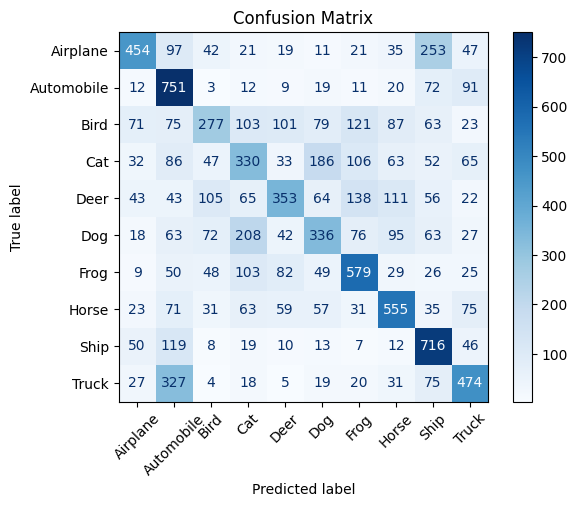

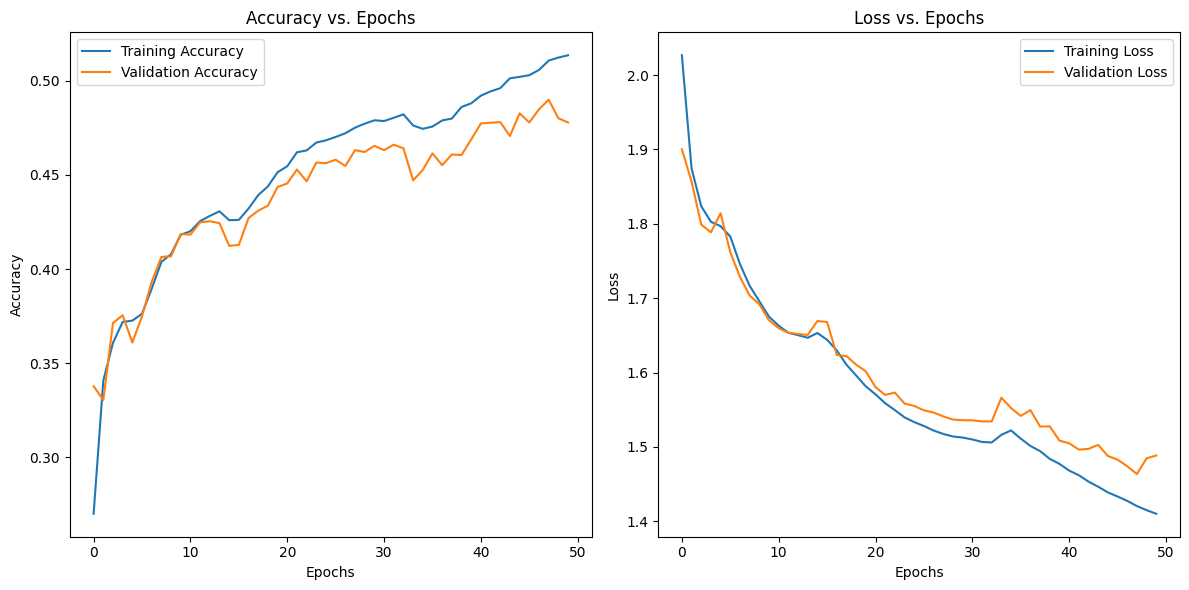

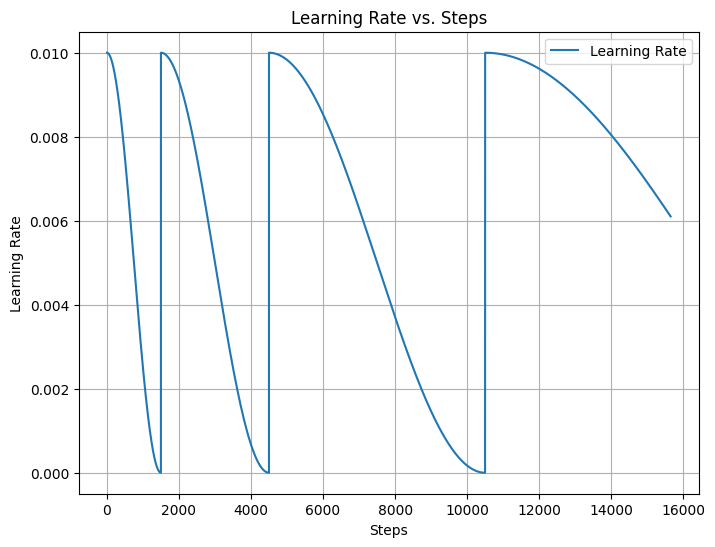

In [ ]:
# Create a shallow model
def create_shallow_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(256, activation='relu'),
        Dropout(0.13),
        Dense(10, activation='softmax')
    ])
    return model

# Learning rate schedule (SGDR)
initial_learning_rate = 0.01
first_decay_steps = 1500
learning_rate_schedule = CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=first_decay_steps,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.001
)

# Compile the model
model = create_shallow_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedule)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the learning rate recorder callback
class LearningRateRecorder(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super().__init__()
        self.schedule = schedule
        self.lrs = []
        self.steps = []

    def on_train_batch_end(self, batch, logs=None):
        # Calculate learning rate for the current step
        step = self.model.optimizer.iterations.numpy()
        lr = self.schedule(step).numpy()  # Get the learning rate from the schedule
        self.lrs.append(lr)
        self.steps.append(step)

# Create the learning rate recorder callback
lr_recorder = LearningRateRecorder(schedule=learning_rate_schedule)

# Train the model with the recorder callback
start_time = time.time()
history = model.fit(
    x_train, y_train_onehot,
    epochs=50,
    batch_size=128,
    validation_data=(x_val, y_val_onehot),
    callbacks=[lr_recorder]
)
training_time = time.time() - start_time

# Evaluate the model on the test set
test_loss, SGD_test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {SGD_test_accuracy:.2f}")
# Print the training time
print(f"Training Time: {training_time:.2f} seconds")

# Generate predictions on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class indices
y_true = y_test.flatten()  # Flatten true labels to match the shape of predictions

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Step 7: Plot Training History
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the learning rate over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(lr_recorder.lrs) + 1), lr_recorder.lrs, label='Learning Rate')
plt.title('Learning Rate vs. Steps')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid()
plt.show()


# Nesterov Accelerated Gradient (NAG)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.2329 - loss: 2.1030 - val_accuracy: 0.3442 - val_loss: 1.8612
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.3550 - loss: 1.8325 - val_accuracy: 0.3794 - val_loss: 1.7612
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.3821 - loss: 1.7581 - val_accuracy: 0.3856 - val_loss: 1.7273
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4037 - loss: 1.6990 - val_accuracy: 0.3905 - val_loss: 1.7003
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.4208 - loss: 1.6633 - val_accuracy: 0.4227 - val_loss: 1.6443
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4316 - loss: 1.6229 - val_accuracy: 0.4254 - val_loss: 1.6267
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4366 - loss: 1.6112 - val_accuracy: 0.4433 - val_loss: 1.6003
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4508 - loss: 1.5812 - val_a

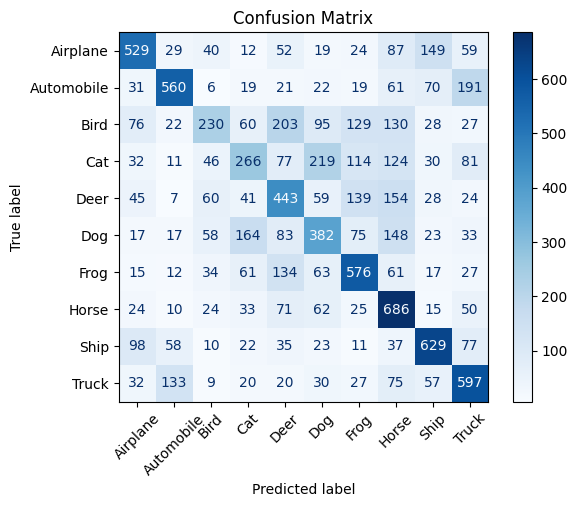

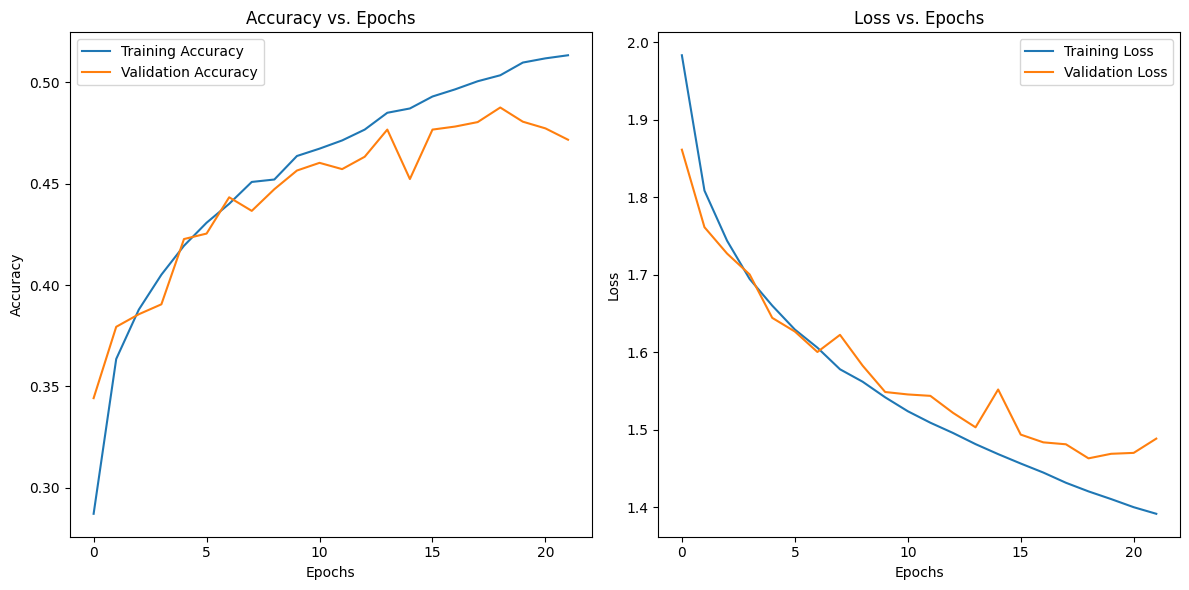

In [ ]:
# Create a shallow model
def create_shallow_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(256, activation='relu'),
        Dropout(0.13),
        Dense(10, activation='softmax')
    ])
    return model

# Compile the model with Nesterov Accelerated Gradient (NAG)
model = create_shallow_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5, nesterov=True)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)

# Train the model
start_time = time.time()
history = model.fit(
    x_train, y_train_onehot,
    epochs=30,
    batch_size=128,
    validation_data=(x_val, y_val_onehot),
    callbacks=[early_stopping],
    verbose=1
)
training_time = time.time() - start_time

# Evaluate the model on the test set
test_loss, NAG_test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=1)
print(f"Test Accuracy: {NAG_test_accuracy:.2f}")
# Print the training time
print(f"Training Time: {training_time:.2f} seconds")

# Generate predictions on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class indices
y_true = y_test.flatten()  # Flatten true labels to match the shape of predictions

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Step 7: Plot Training History
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# RMSProp

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.2353 - loss: 2.1016 - val_accuracy: 0.3389 - val_loss: 1.8629
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.3439 - loss: 1.8484 - val_accuracy: 0.3510 - val_loss: 1.8157
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3780 - loss: 1.7703 - val_accuracy: 0.3839 - val_loss: 1.7304
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3958 - loss: 1.7124 - val_accuracy: 0.3946 - val_loss: 1.6886
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.4077 - loss: 1.6759 - val_accuracy: 0.3868 - val_loss: 1.7186
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.4221 - loss: 1.6443 - val_accuracy: 0.4234 - val_loss: 1.6395
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.4354 - loss: 1.6210 - val_accuracy: 0.4311 - val_loss: 1.6166
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.4475 - loss: 1.5916 - val_

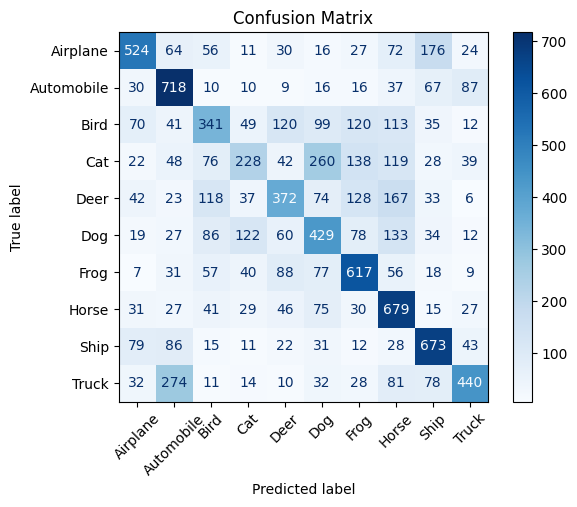

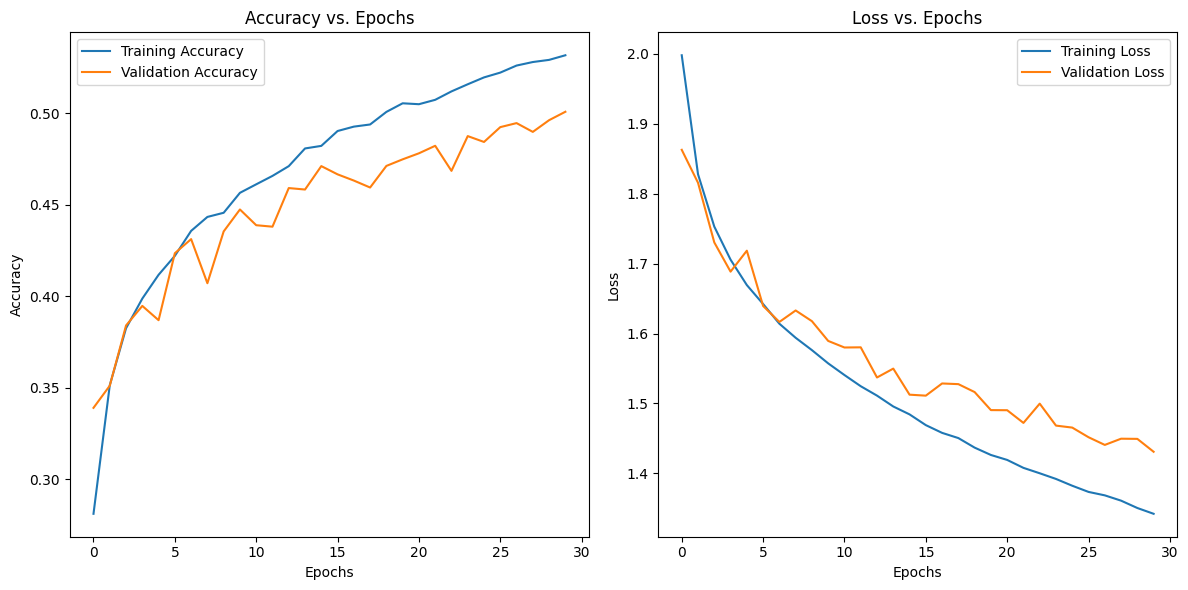

In [ ]:
# Create a shallow model
def create_shallow_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(256, activation='relu'),
        Dropout(0.13),
        Dense(10, activation='softmax')
    ])
    return model

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=4,          # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)


# Compile the model with RMSProp optimizer
model = create_shallow_model()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.7)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
start_time = time.time()
history = model.fit(
    x_train, y_train_onehot,
    epochs=30,
    batch_size=128,
    validation_data=(x_val, y_val_onehot),
    callbacks=[early_stopping]
)
training_time = time.time() - start_time

# Evaluate the model on the test set
test_loss, RMSProp_test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {RMSProp_test_accuracy:.2f}")
# Print the training time
print(f"Training Time: {training_time:.2f} seconds")

# Generate predictions on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class indices
y_true = y_test.flatten()  # Flatten true labels to match the shape of predictions

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Step 7: Plot Training History
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Nadam

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2511 - loss: 2.0615 - val_accuracy: 0.3492 - val_loss: 1.8279
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.3601 - loss: 1.8147 - val_accuracy: 0.3885 - val_loss: 1.7389
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.3893 - loss: 1.7378 - val_accuracy: 0.4036 - val_loss: 1.6923
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4086 - loss: 1.6996 - val_accuracy: 0.4240 - val_loss: 1.6487
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4247 - loss: 1.6542 - val_accuracy: 0.4324 - val_loss: 1.6237
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4285 - loss: 1.6289 - val_accuracy: 0.4333 - val_loss: 1.6194
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4429 - loss: 1.5995 - val_accuracy: 0.4484 - val_loss: 1.5827
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4428 - loss: 1.5914 - val_a

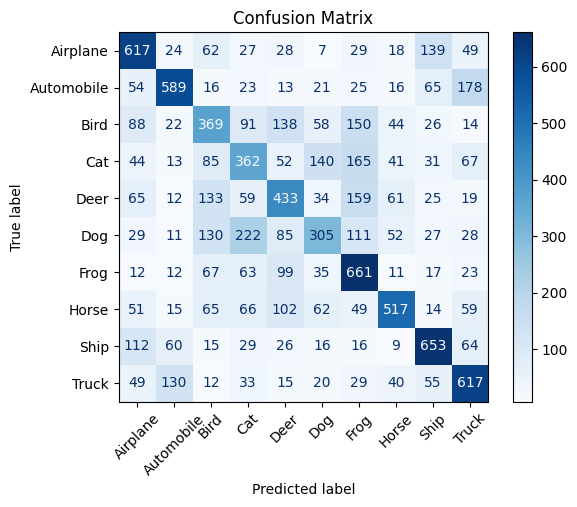

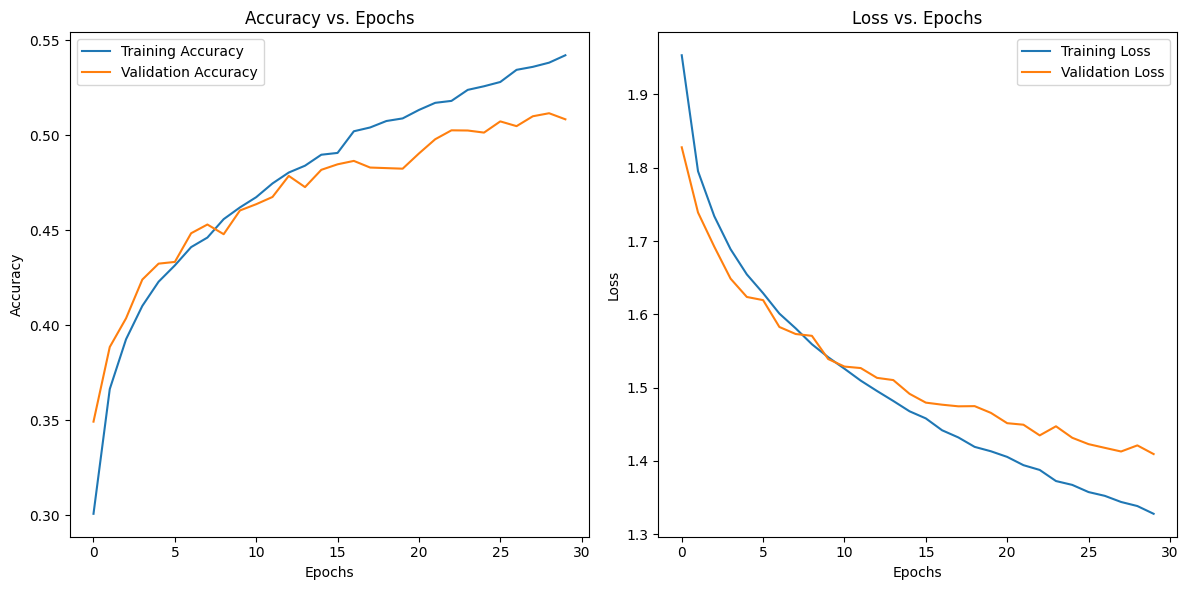

In [ ]:
# Create a shallow model
def create_shallow_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    return model

# Compile the model with Nadam optimizer
model = create_shallow_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)


# Train the model
start_time = time.time()
history = model.fit(
    x_train, y_train_onehot,
    epochs=30,
    batch_size=128,
    validation_data=(x_val, y_val_onehot),
    callbacks=[early_stopping]
)
training_time = time.time() - start_time

# Evaluate the model on the test set
test_loss, Nadam_test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {Nadam_test_accuracy:.2f}")
# Print the training time
print(f"Training Time: {training_time:.2f} seconds")

# Generate predictions on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class indices
y_true = y_test.flatten()  # Flatten true labels to match the shape of predictions

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)


# Display the confusion matrix
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Step 7: Plot Training History
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Exponential Decay

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.2629 - loss: 2.1782 - val_accuracy: 0.3593 - val_loss: 1.7882
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3866 - loss: 1.7460 - val_accuracy: 0.4017 - val_loss: 1.6890
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4089 - loss: 1.6780 - val_accuracy: 0.4053 - val_loss: 1.6766
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.4272 - loss: 1.6222 - val_accuracy: 0.4330 - val_loss: 1.5995
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4462 - loss: 1.5809 - val_accuracy: 0.4397 - val_loss: 1.5837
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.4575 - loss: 1.5548 - val_accuracy: 0.4414 - val_loss: 1.5840
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4598 - loss: 1.5417 - val_accuracy: 0.4563 - val_loss: 1.5454
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4653 - loss: 1.5207 - val_

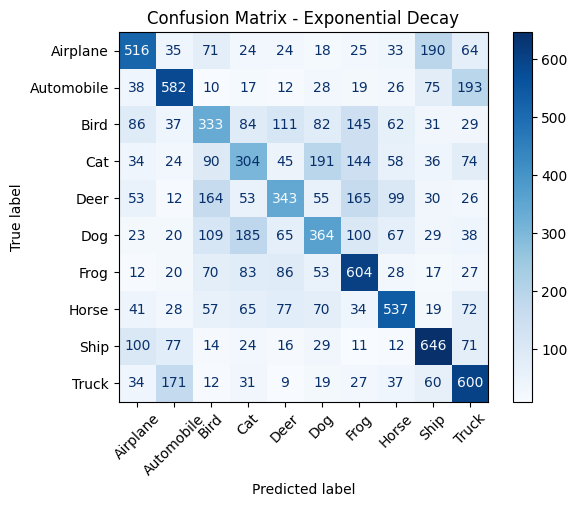

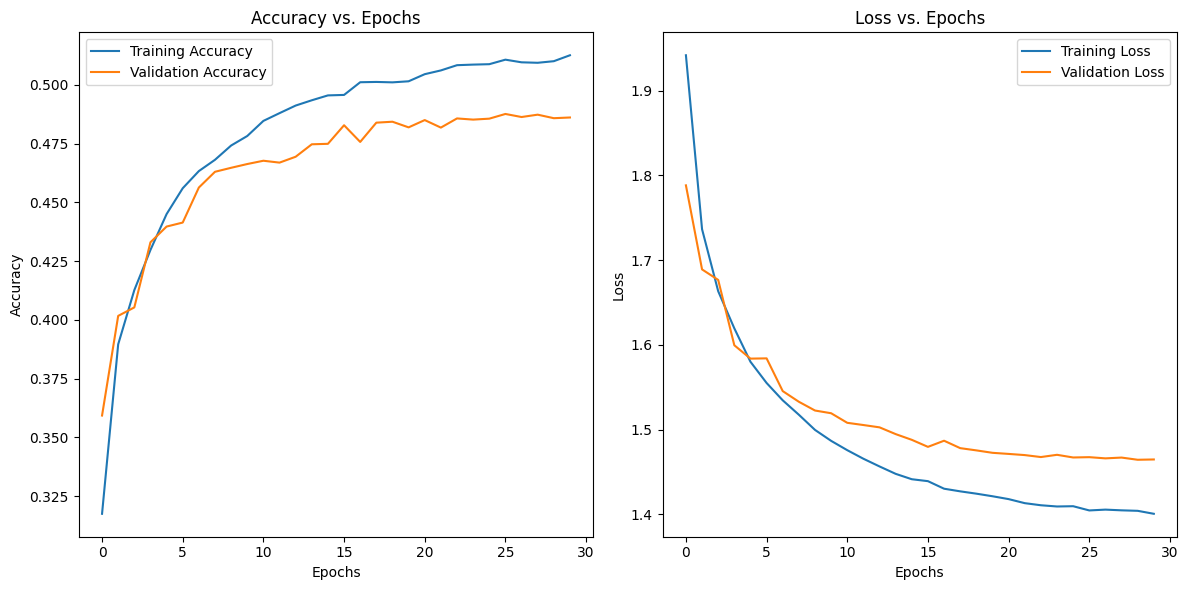

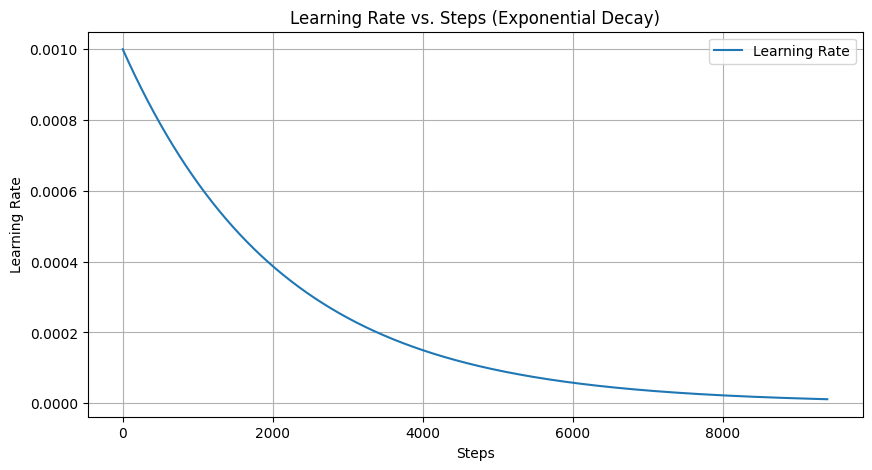

In [ ]:
# Create a shallow model
def create_shallow_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(256, activation='relu'),
        Dropout(0.06),
        Dense(10, activation='softmax')
    ])
    return model


# Define the Exponential Decay schedule
initial_learning_rate = 0.001
decay_rate = 0.15
decay_steps = 4000  # Decay the learning rate every 1000 steps
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False  # Continuous decay (set to True for discrete steps)
)

# Compile the model with Exponential Decay
model = create_shallow_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate_schedule)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the learning rate recorder callback
class LearningRateRecorder(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super().__init__()
        self.schedule = schedule
        self.lrs = []
        self.steps = []

    def on_train_batch_end(self, batch, logs=None):
        # Calculate learning rate for the current step
        step = self.model.optimizer.iterations.numpy()
        lr = self.schedule(step).numpy()  # Get the learning rate from the schedule
        self.lrs.append(lr)
        self.steps.append(step)

# Create the learning rate recorder callback
lr_recorder = LearningRateRecorder(schedule=learning_rate_schedule)

# Train the model
start_time = time.time()
history = model.fit(
    x_train, y_train_onehot,
    epochs=30,
    batch_size=128,
    validation_data=(x_val, y_val_onehot),
    callbacks=[lr_recorder]
)
training_time = time.time() - start_time

# Evaluate the model on the test set
test_loss, Exponential_test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {Exponential_test_accuracy:.2f}")
# Print the training time
print(f"Training Time: {training_time:.2f} seconds")

# Generate predictions on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class indices
y_true = y_test.flatten()  # Flatten true labels to match the shape of predictions

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)


# Display the confusion matrix
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Exponential Decay")
plt.show()

# Step 7: Plot Training History
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Learning Rate vs. Steps
plt.figure(figsize=(10, 5))
plt.plot(lr_recorder.steps, lr_recorder.lrs, label='Learning Rate')
plt.title('Learning Rate vs. Steps (Exponential Decay)')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

# Step Decay

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.2577 - loss: 2.1561 - val_accuracy: 0.3672 - val_loss: 1.7781 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.3673 - loss: 1.7716 - val_accuracy: 0.4023 - val_loss: 1.6867 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3955 - loss: 1.7032 - val_accuracy: 0.4096 - val_loss: 1.6481 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4124 - loss: 1.6622 - val_accuracy: 0.4025 - val_loss: 1.6438 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4209 - loss: 1.6299 - val_accuracy: 0.4293 - val_loss: 1.6022 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.4282 - loss: 1.6036 - val_accuracy: 0.4372 - val_loss: 1.5856 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4344 - loss:

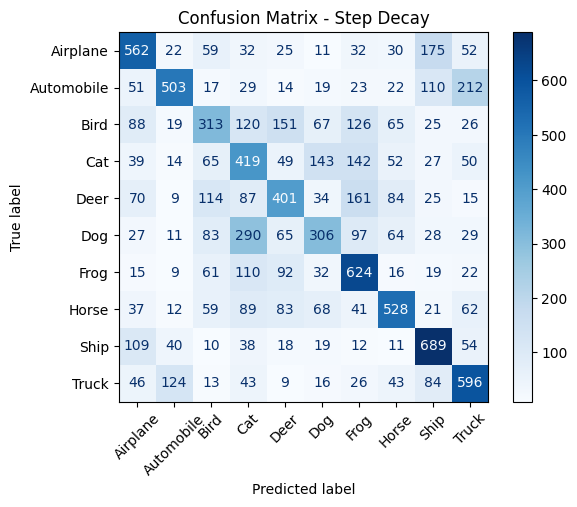

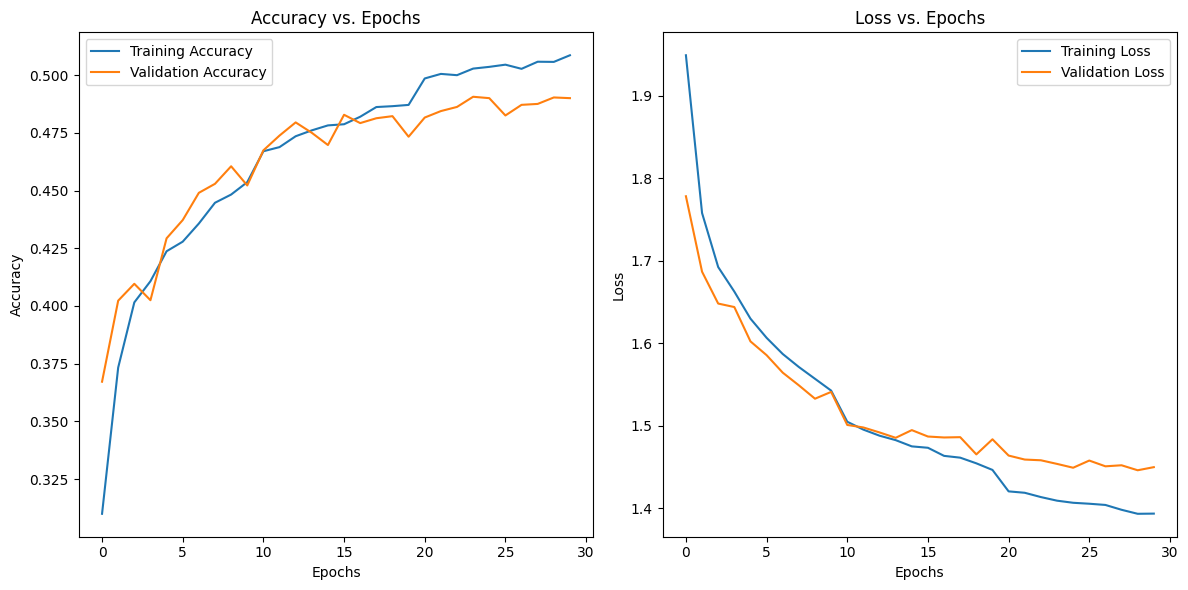

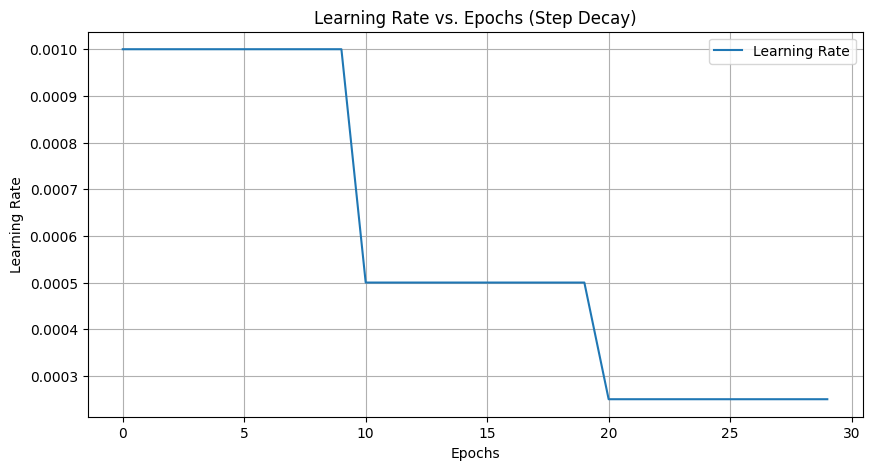

In [ ]:

# Create a shallow model
def create_shallow_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(256, activation='relu'),
        Dropout(0.13),
        Dense(10, activation='softmax')
    ])
    return model

# Define the Step Decay schedule
def step_decay(epoch):
    initial_learning_rate = 0.001
    drop = 0.5
    epochs_drop = 10
    learning_rate = initial_learning_rate * (drop ** (epoch // epochs_drop))
    return learning_rate

# Callback for Step Decay
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

# Compile the model with SGD and Step Decay
model = create_shallow_model()
optimizer = tf.keras.optimizers.Nadam()
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create the learning rate recorder callback
class LearningRateRecorder(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super().__init__()
        self.schedule = schedule
        self.lrs = []
        self.steps = []

    def on_epoch_end(self, epoch, logs=None):
        # Calculate learning rate for the current epoch
        lr = self.schedule(epoch)
        self.lrs.append(lr)
        self.steps.append(epoch)

# Create the learning rate recorder callback
lr_recorder = LearningRateRecorder(schedule=step_decay)

# Train the model with Step Decay
start_time = time.time()
history = model.fit(
    x_train, y_train_onehot,
    epochs=30,
    batch_size=128,
    validation_data=(x_val, y_val_onehot),
    callbacks=[lr_scheduler , lr_recorder]
)
training_time = time.time() - start_time

# Evaluate the model on the test set
test_loss, Step_test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {Step_test_accuracy:.2f}")
# Print the training time
print(f"Training Time: {training_time:.2f} seconds")

# Generate predictions on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class indices
y_true = y_test.flatten()  # Flatten true labels to match the shape of predictions

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Step Decay")
plt.show()

# Step 7: Plot Training History
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Plot Learning Rate vs. Epochs (Step Decay)
plt.figure(figsize=(10, 5))
plt.plot(lr_recorder.steps, lr_recorder.lrs, label='Learning Rate')
plt.title('Learning Rate vs. Epochs (Step Decay)')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()




# Accuracy Comparison

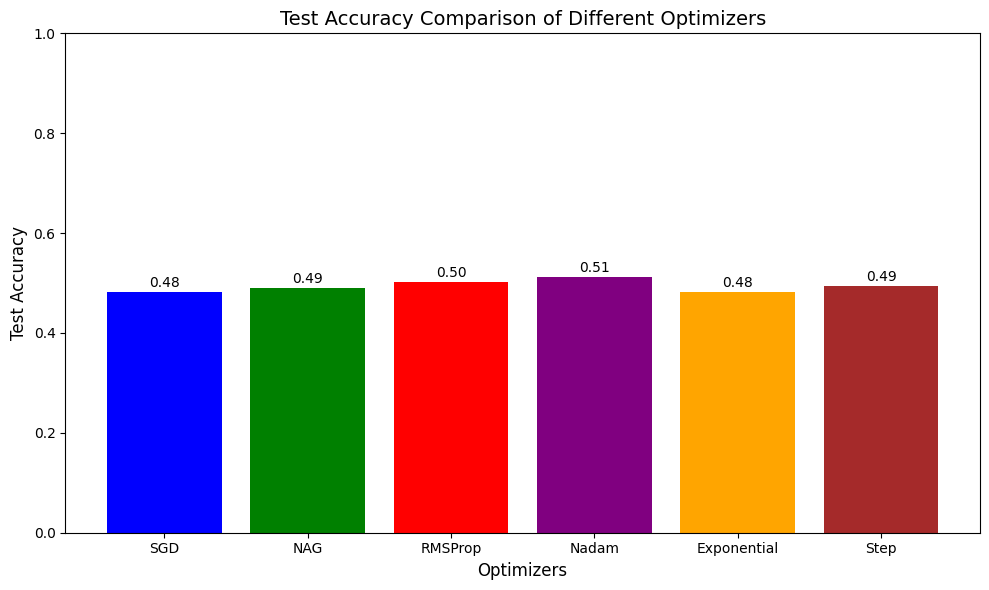

In [ ]:
import matplotlib.pyplot as plt

# Collect the test accuracies for each optimizer
optimizers = ['SGD', 'NAG', 'RMSProp', 'Nadam', 'Exponential', 'Step']
accuracies = [
    SGD_test_accuracy,
    NAG_test_accuracy,
    RMSProp_test_accuracy,
    Nadam_test_accuracy,
    Exponential_test_accuracy,
    Step_test_accuracy
]

# Plot the test accuracies as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(optimizers, accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])

# Adding titles and labels
plt.title('Test Accuracy Comparison of Different Optimizers', fontsize=14)
plt.xlabel('Optimizers', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim([0, 1])  # Accuracy ranges from 0 to 1

# Display the values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()
